# SMOTE + GridSearch + KNN - Stress Level Detection

Implementasi KNN dengan kombinasi SMOTE untuk mengatasi ketidakseimbangan kelas dan GridSearchCV untuk optimasi hyperparameter dalam klasifikasi tingkat stress.

**Skenario**: SMOTE + GridSearch + KNN

In [1]:
!pip install --upgrade imbalanced-learn
!pip install --upgrade scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn

  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.1
    Uninstalling scikit-learn-1.7.1:
      Successfully uninstalled scikit-learn-1.7.1
  Using cached scikit_learn-1.7.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import time

print("✅ Library berhasil diimport")

✅ Library berhasil diimport


## 1. Data Loading dan Preprocessing

In [4]:
FILE_PATH = './dataset/fix dataset 1031.csv'

# Read CSV with semicolon as separator and handle mixed decimal separators
df = pd.read_csv(FILE_PATH, sep=';', decimal='.')
dataset = df.copy()

# Tampilkan Semua row pada kolom pertama yang memiliki nilai NaN
print("📊 DATASET INFORMATION:")
print("Jumlah baris yang memiliki nilai NaN pada kolom pertama:", dataset[dataset.columns[0]].isna().sum())

# Bersihkan data dengan menghapus baris yang memiliki nilai NaN pada kolom pertama
dataset = dataset.dropna(subset=[dataset.columns[0]])

print("Dataset shape:", dataset.shape)
display(dataset.head())

📊 DATASET INFORMATION:
Jumlah baris yang memiliki nilai NaN pada kolom pertama: 65
Dataset shape: (1031, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1.0,Male,27.0,Software Engineer,06.01,6.0,42.0,6.0,Overweight,126/83,77.0,4200.0,NaN
1,2.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
2,3.0,Male,28.0,Doctor,06.02,6.0,60.0,8.0,Normal,125/80,75.0,10000.0,NaN
3,4.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea
4,5.0,Male,28.0,Sales Representative,05.09,4.0,30.0,8.0,Obese,140/90,85.0,3000.0,Sleep Apnea


In [5]:
# Fill missing values in Sleep Disorder with 'Normal'
dataset['Sleep Disorder'] = dataset['Sleep Disorder'].fillna('Normal')

# Split Blood Pressure column
if 'Blood Pressure' in dataset.columns:
    dataset[['Systolic', 'Diastolic']] = dataset['Blood Pressure'].str.split('/', expand=True)
    dataset['Systolic'] = pd.to_numeric(dataset['Systolic'], errors='coerce')
    dataset['Diastolic'] = pd.to_numeric(dataset['Diastolic'], errors='coerce')
    dataset = dataset.drop('Blood Pressure', axis=1)

# Clean numeric columns
kolom_numerik = ["Sleep Duration", "Heart Rate", "Daily Steps", "Systolic", "Diastolic"]
for col in kolom_numerik:
    if col in dataset.columns:
        dataset[col] = dataset[col].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
        dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

print("✅ Data preprocessing selesai")

✅ Data preprocessing selesai


## 2. Target Encoding dan Feature Selection

In [6]:
# Label encoding for target
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(dataset['Sleep Disorder'])

print("Target classes:", label_encoder.classes_)
print("Encoded values:", np.unique(target_encoded))

# Show class distribution BEFORE SMOTE
print("\n=== DISTRIBUSI KELAS BEFORE SMOTE ====")
class_counts_before = pd.Series(target_encoded).value_counts().sort_index()
for i, count in enumerate(class_counts_before):
    print(f"{label_encoder.classes_[i]}: {count} samples")

total_before = len(target_encoded)
print(f"\nTotal samples before SMOTE: {total_before}")

Target classes: ['Insomnia' 'Normal' 'Sleep Apnea']
Encoded values: [0 1 2]

=== DISTRIBUSI KELAS BEFORE SMOTE ====
Insomnia: 296 samples
Normal: 438 samples
Sleep Apnea: 297 samples

Total samples before SMOTE: 1031


In [7]:
# Select features
feature_columns = ["Gender", "Age", "Occupation", "Sleep Duration", "Quality of Sleep",
                  "Physical Activity Level", "Stress Level", "BMI Category", "Systolic", "Diastolic"]

# Filter only existing columns
available_features = [col for col in feature_columns if col in dataset.columns]
features = dataset[available_features]

print("Selected features:", available_features)
print("Features shape:", features.shape)

Selected features: ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Systolic', 'Diastolic']
Features shape: (1031, 10)


## 3. Data Splitting

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded
)

print("=== DATA SPLIT ====")
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

print("\nDistribusi y_train BEFORE SMOTE:")
train_dist_before = pd.Series(y_train).value_counts().sort_index()
for i, count in enumerate(train_dist_before):
    print(f"{label_encoder.classes_[i]}: {count} samples")

=== DATA SPLIT ====
Training set: 824 samples
Test set: 207 samples

Distribusi y_train BEFORE SMOTE:
Insomnia: 237 samples
Normal: 350 samples
Sleep Apnea: 237 samples


## 4. Pipeline Setup dengan SMOTE

In [9]:
# Define numerical and categorical features
numerical_features = [col for col in available_features if features[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in available_features if features[col].dtype == 'object']

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

# Create preprocessors
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

print("✅ Preprocessor pipeline created")

Numerical features: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Systolic', 'Diastolic']
Categorical features: ['Gender', 'Occupation', 'BMI Category']
✅ Preprocessor pipeline created


## 5. SMOTE Application untuk Melihat Efek Balancing

In [10]:
# Apply preprocessing to see the effect of SMOTE clearly
X_train_processed = preprocessor.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("=== COMPARISON BEFORE vs AFTER SMOTE ====")
print("\nBEFORE SMOTE:")
for i, count in enumerate(train_dist_before):
    print(f"{label_encoder.classes_[i]}: {count} samples")
print(f"Total: {len(y_train)} samples")

print("\nAFTER SMOTE:")
train_dist_after = pd.Series(y_train_smote).value_counts().sort_index()
for i, count in enumerate(train_dist_after):
    print(f"{label_encoder.classes_[i]}: {count} samples")
print(f"Total: {len(y_train_smote)} samples")

# Calculate increase
print("\nINCREASE PER CLASS:")
for i in range(len(label_encoder.classes_)):
    before = train_dist_before.iloc[i] if i < len(train_dist_before) else 0
    after = train_dist_after.iloc[i] if i < len(train_dist_after) else 0
    increase = after - before
    print(f"{label_encoder.classes_[i]}: +{increase} samples (from {before} to {after})")

=== COMPARISON BEFORE vs AFTER SMOTE ====

BEFORE SMOTE:
Insomnia: 237 samples
Normal: 350 samples
Sleep Apnea: 237 samples
Total: 824 samples

AFTER SMOTE:
Insomnia: 350 samples
Normal: 350 samples
Sleep Apnea: 350 samples
Total: 1050 samples

INCREASE PER CLASS:
Insomnia: +113 samples (from 237 to 350)
Normal: +0 samples (from 350 to 350)
Sleep Apnea: +113 samples (from 237 to 350)


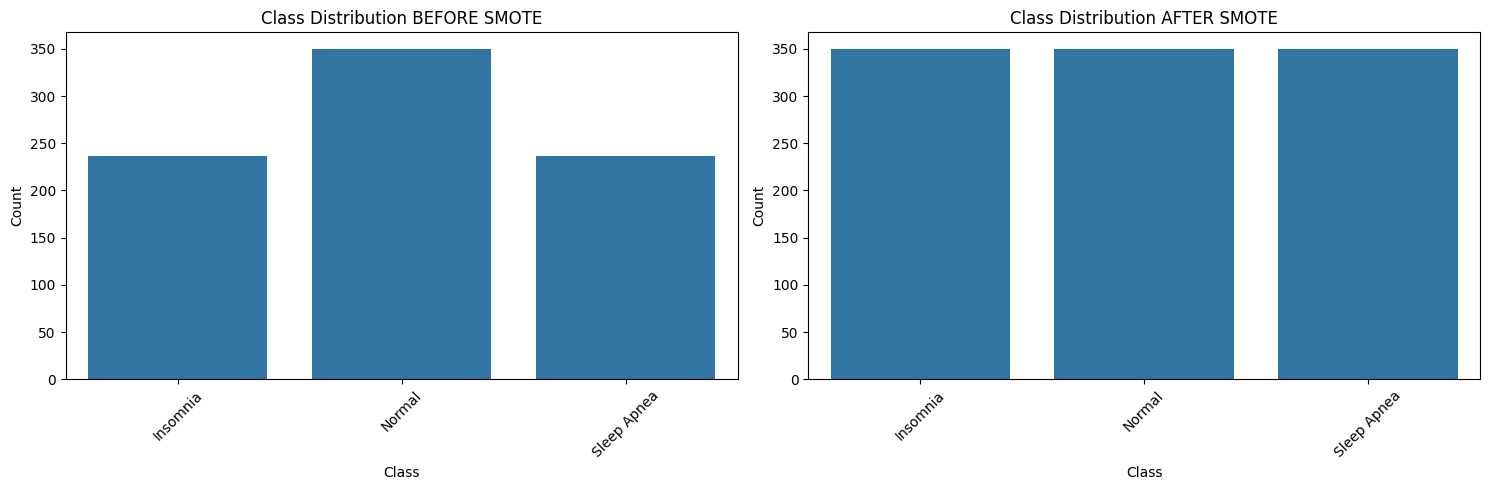

In [11]:
# Visualize class distribution before and after SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Before SMOTE
before_data = pd.DataFrame({
    'Class': [label_encoder.classes_[i] for i in train_dist_before.index],
    'Count': train_dist_before.values
})
sns.barplot(data=before_data, x='Class', y='Count', ax=ax1)
ax1.set_title('Class Distribution BEFORE SMOTE')
ax1.tick_params(axis='x', rotation=45)

# After SMOTE
after_data = pd.DataFrame({
    'Class': [label_encoder.classes_[i] for i in train_dist_after.index],
    'Count': train_dist_after.values
})
sns.barplot(data=after_data, x='Class', y='Count', ax=ax2)
ax2.set_title('Class Distribution AFTER SMOTE')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Baseline Model (Before GridSearch)

In [12]:
# Create baseline SMOTE + KNN pipeline (default parameters)
baseline_smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# Train baseline model
print("Training baseline SMOTE + KNN model...")
baseline_smote_pipeline.fit(X_train, y_train)
baseline_pred = baseline_smote_pipeline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, baseline_pred)

print("=== BASELINE MODEL (BEFORE GridSearch) ====")
print("Default hyperparameters:")
knn_params = baseline_smote_pipeline.named_steps['knn'].get_params()
important_params = ['n_neighbors', 'weights', 'algorithm', 'metric', 'p']
for param in important_params:
    if param in knn_params:
        print(f"  {param}: {knn_params[param]}")

print(f"\nBaseline accuracy with SMOTE: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")

Training baseline SMOTE + KNN model...
=== BASELINE MODEL (BEFORE GridSearch) ====
Default hyperparameters:
  n_neighbors: 5
  weights: uniform
  algorithm: auto
  metric: minkowski
  p: 2

Baseline accuracy with SMOTE: 0.8599 (85.99%)


## 7. GridSearchCV untuk Optimasi Hyperparameter dengan SMOTE

In [13]:
# Define parameter grid for GridSearch
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2]  # Only relevant for minkowski metric
}

print("Parameter grid for GridSearch dengan SMOTE:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations to test: {np.prod([len(v) for v in param_grid.values()])}")

Parameter grid for GridSearch dengan SMOTE:
  knn__n_neighbors: [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
  knn__weights: ['uniform', 'distance']
  knn__algorithm: ['auto', 'ball_tree', 'kd_tree', 'brute']
  knn__metric: ['euclidean', 'manhattan', 'minkowski']
  knn__p: [1, 2]

Total combinations to test: 480


In [14]:
# Create pipeline for GridSearch with SMOTE
grid_smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# Perform GridSearchCV
print("Starting GridSearchCV with SMOTE + KNN...")
print("This may take several minutes...")

start_time = time.time()

grid_search_smote = GridSearchCV(
    grid_smote_pipeline,
    param_grid,
    cv=5,  # 5-fold cross validation
    scoring='accuracy',
    n_jobs=1,  # Sequential processing (avoids pickling issues with ImbPipeline)
    verbose=1
)

grid_search_smote.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n✅ GridSearchCV dengan SMOTE completed in {elapsed_time:.2f} seconds")

Starting GridSearchCV with SMOTE + KNN...
This may take several minutes...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits

✅ GridSearchCV dengan SMOTE completed in 86.68 seconds


## 8. GridSearch Results

In [15]:
# Display GridSearch results
print("=== GRIDSEARCH + SMOTE RESULTS ====")
print("\nBest parameters found:")
for param, value in grid_search_smote.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation score: {grid_search_smote.best_score_:.4f} ({grid_search_smote.best_score_*100:.2f}%)")

# Test the best model
best_model_smote = grid_search_smote.best_estimator_
y_pred_grid_smote = best_model_smote.predict(X_test)
grid_smote_accuracy = accuracy_score(y_test, y_pred_grid_smote)

print(f"Test set accuracy with best SMOTE + GridSearch model: {grid_smote_accuracy:.4f} ({grid_smote_accuracy*100:.2f}%)")

=== GRIDSEARCH + SMOTE RESULTS ====

Best parameters found:
  knn__algorithm: auto
  knn__metric: euclidean
  knn__n_neighbors: 7
  knn__p: 1
  knn__weights: distance

Best cross-validation score: 0.9175 (91.75%)
Test set accuracy with best SMOTE + GridSearch model: 0.9082 (90.82%)


In [16]:
# Compare Before vs After GridSearch (both with SMOTE)
print("=== COMPARISON: BEFORE vs AFTER GridSearch (dengan SMOTE) ====")
print("\nBEFORE GridSearch (SMOTE + default KNN parameters):")
print(f"  n_neighbors: 5")
print(f"  weights: uniform")
print(f"  algorithm: auto")
print(f"  metric: minkowski")
print(f"  p: 2")
print(f"  Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")

print("\nAFTER GridSearch (SMOTE + optimized KNN parameters):")
for param, value in grid_search_smote.best_params_.items():
    param_name = param.replace('knn__', '')
    print(f"  {param_name}: {value}")
print(f"  Accuracy: {grid_smote_accuracy:.4f} ({grid_smote_accuracy*100:.2f}%)")

improvement = grid_smote_accuracy - baseline_accuracy
print(f"\nImprovement: {improvement:.4f} ({improvement*100:.2f} percentage points)")

if improvement > 0:
    print("✅ GridSearch improved SMOTE + KNN model performance!")
elif improvement == 0:
    print("➖ No improvement from GridSearch")
else:
    print("⚠️ GridSearch resulted in lower performance (may indicate overfitting)")

=== COMPARISON: BEFORE vs AFTER GridSearch (dengan SMOTE) ====

BEFORE GridSearch (SMOTE + default KNN parameters):
  n_neighbors: 5
  weights: uniform
  algorithm: auto
  metric: minkowski
  p: 2
  Accuracy: 0.8599 (85.99%)

AFTER GridSearch (SMOTE + optimized KNN parameters):
  algorithm: auto
  metric: euclidean
  n_neighbors: 7
  p: 1
  weights: distance
  Accuracy: 0.9082 (90.82%)

Improvement: 0.0483 (4.83 percentage points)
✅ GridSearch improved SMOTE + KNN model performance!


## 9. Detailed Performance Analysis

In [17]:
# Detailed classification report
print("=== DETAILED PERFORMANCE ANALYSIS ====")
print("\nClassification Report (Best SMOTE + GridSearch Model):")
print(classification_report(y_test, y_pred_grid_smote, target_names=label_encoder.classes_))

=== DETAILED PERFORMANCE ANALYSIS ====

Classification Report (Best SMOTE + GridSearch Model):
              precision    recall  f1-score   support

    Insomnia       0.89      0.86      0.88        59
      Normal       0.90      0.95      0.93        88
 Sleep Apnea       0.93      0.88      0.91        60

    accuracy                           0.91       207
   macro avg       0.91      0.90      0.90       207
weighted avg       0.91      0.91      0.91       207



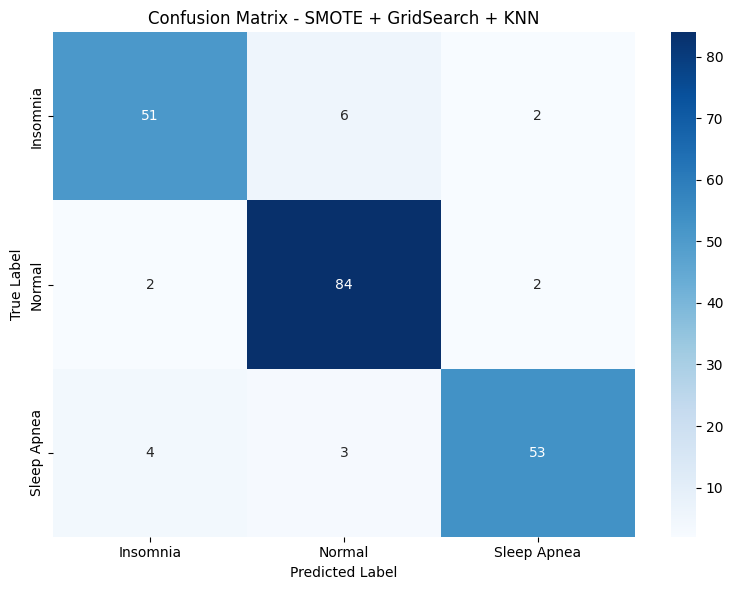

In [18]:
# Confusion Matrix
cm_grid_smote = confusion_matrix(y_test, y_pred_grid_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_grid_smote, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - SMOTE + GridSearch + KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 10. Comparison dengan Model Lain

In [19]:
# Train KNN murni untuk comparison
knn_murni = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

knn_murni.fit(X_train, y_train)
pred_murni = knn_murni.predict(X_test)
accuracy_murni = accuracy_score(y_test, pred_murni)

# Train KNN + SMOTE tanpa GridSearch
knn_smote_only = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

knn_smote_only.fit(X_train, y_train)
pred_smote_only = knn_smote_only.predict(X_test)
accuracy_smote_only = accuracy_score(y_test, pred_smote_only)

print("=== COMPARISON: SEMUA MODEL ====")
print(f"1. KNN Murni: {accuracy_murni:.4f} ({accuracy_murni*100:.2f}%)")
print(f"2. KNN + SMOTE: {accuracy_smote_only:.4f} ({accuracy_smote_only*100:.2f}%)")
print(f"3. SMOTE + GridSearch + KNN: {grid_smote_accuracy:.4f} ({grid_smote_accuracy*100:.2f}%)")

print(f"\nImprovement SMOTE vs Murni: {(accuracy_smote_only - accuracy_murni)*100:+.2f} pp")
print(f"Improvement SMOTE+GridSearch vs Murni: {(grid_smote_accuracy - accuracy_murni)*100:+.2f} pp")
print(f"Improvement SMOTE+GridSearch vs SMOTE: {(grid_smote_accuracy - accuracy_smote_only)*100:+.2f} pp")

=== COMPARISON: SEMUA MODEL ====
1. KNN Murni: 0.8599 (85.99%)
2. KNN + SMOTE: 0.8599 (85.99%)
3. SMOTE + GridSearch + KNN: 0.9082 (90.82%)

Improvement SMOTE vs Murni: +0.00 pp
Improvement SMOTE+GridSearch vs Murni: +4.83 pp
Improvement SMOTE+GridSearch vs SMOTE: +4.83 pp


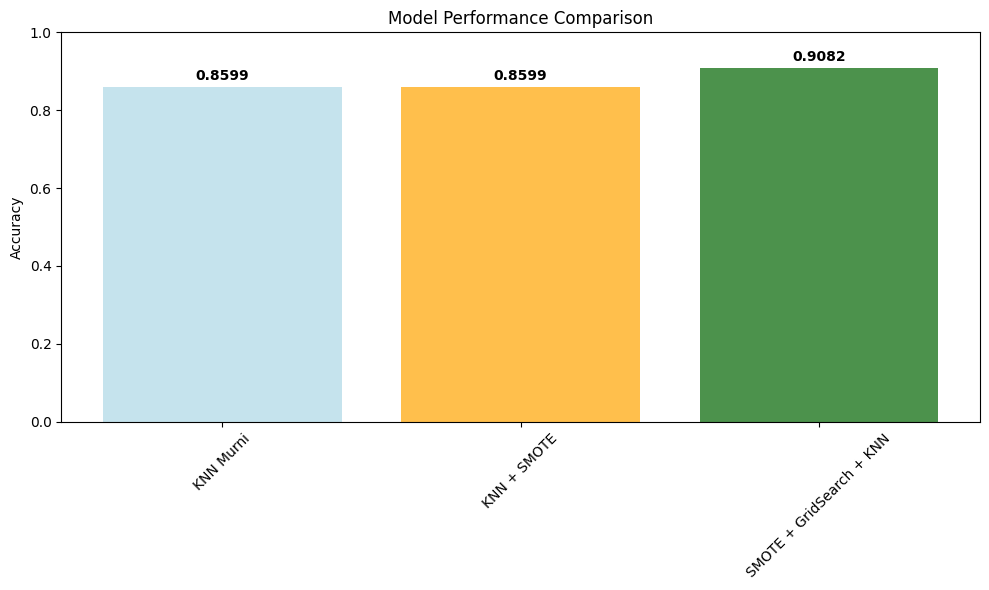

In [20]:
# Visualize comparison
models = ['KNN Murni', 'KNN + SMOTE', 'SMOTE + GridSearch + KNN']
accuracies = [accuracy_murni, accuracy_smote_only, grid_smote_accuracy]
colors = ['lightblue', 'orange', 'darkgreen']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors, alpha=0.7)
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 11. Top 10 Best Parameter Combinations

In [21]:
# Display top 10 parameter combinations
results_df = pd.DataFrame(grid_search_smote.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[['mean_test_score', 'std_test_score', 'params']]

print("=== TOP 10 PARAMETER COMBINATIONS (SMOTE + GridSearch) ====")
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    print(f"\n{i}. Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   Parameters: {row['params']}")

=== TOP 10 PARAMETER COMBINATIONS (SMOTE + GridSearch) ====

1. Score: 0.9175 (±0.0152)
   Parameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}

2. Score: 0.9175 (±0.0152)
   Parameters: {'knn__algorithm': 'auto', 'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}

3. Score: 0.9175 (±0.0152)
   Parameters: {'knn__algorithm': 'auto', 'knn__metric': 'minkowski', 'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}

4. Score: 0.9175 (±0.0152)
   Parameters: {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}

5. Score: 0.9175 (±0.0152)
   Parameters: {'knn__algorithm': 'brute', 'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'distance'}

6. Score: 0.9175 (±0.0152)
   Parameters: {'knn__algorithm': 'brute', 'knn__metric': 'minkowski', 'knn__n_neighbors': 7, 'knn__

## 12. K Value Analysis

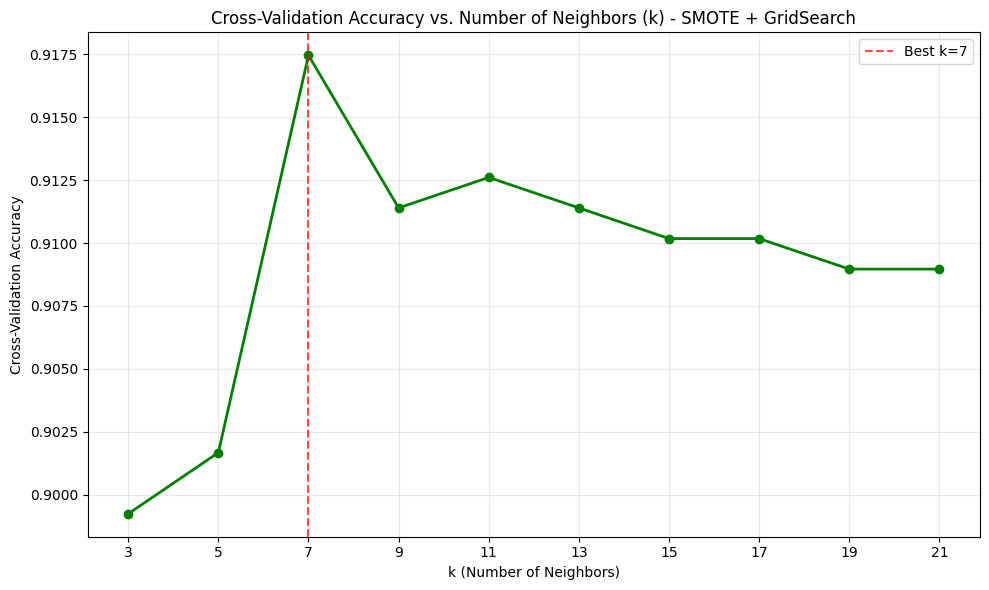


=== K OPTIMAL untuk SMOTE + GridSearch + KNN ====
Best k: 7
Best CV score with k=7: 0.9175


In [22]:
# Analyze the effect of different k values specifically
k_values = param_grid['knn__n_neighbors']
k_scores = []

# Filter results for the best other parameters but varying k
best_params_except_k = {k: v for k, v in grid_search_smote.best_params_.items() if k != 'knn__n_neighbors'}

for k in k_values:
    # Find results with this k and best other parameters
    matching_rows = results_df[
        (results_df['param_knn__n_neighbors'] == k) &
        (results_df['param_knn__weights'] == best_params_except_k.get('knn__weights')) &
        (results_df['param_knn__algorithm'] == best_params_except_k.get('knn__algorithm')) &
        (results_df['param_knn__metric'] == best_params_except_k.get('knn__metric')) &
        (results_df['param_knn__p'] == best_params_except_k.get('knn__p'))
    ]

    if not matching_rows.empty:
        k_scores.append(matching_rows['mean_test_score'].iloc[0])
    else:
        k_scores.append(0)

# Plot k vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, marker='o', linewidth=2, markersize=6, color='green')
best_k = grid_search_smote.best_params_['knn__n_neighbors']
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
plt.title('Cross-Validation Accuracy vs. Number of Neighbors (k) - SMOTE + GridSearch')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(k_values)
plt.tight_layout()
plt.show()

print(f"\n=== K OPTIMAL untuk SMOTE + GridSearch + KNN ====")
print(f"Best k: {best_k}")
print(f"Best CV score with k={best_k}: {grid_search_smote.best_score_:.4f}")

## 13. Final Summary

In [23]:
print("=" * 70)
print("FINAL SUMMARY - SMOTE + GRIDSEARCH + KNN")
print("=" * 70)

print("\n📊 DATASET INFORMATION:")
print(f"   Total samples: {len(dataset)}")
print(f"   Features used: {len(available_features)}")
print(f"   Classes: {len(label_encoder.classes_)} ({', '.join(label_encoder.classes_)})")

print("\n🔄 SMOTE BALANCING:")
print("   Before SMOTE:")
for i, count in enumerate(train_dist_before):
    print(f"     {label_encoder.classes_[i]}: {count} samples")
print("   After SMOTE:")
for i, count in enumerate(train_dist_after):
    print(f"     {label_encoder.classes_[i]}: {count} samples")

print("\n🔍 GRIDSEARCH CONFIGURATION:")
print(f"   Total parameter combinations tested: {len(results_df)}")
print(f"   Cross-validation folds: 5")
print(f"   Search time: {elapsed_time:.2f} seconds")

print("\n📈 PERFORMANCE RESULTS:")
print(f"   KNN Murni: {accuracy_murni:.4f} ({accuracy_murni*100:.2f}%)")
print(f"   KNN + SMOTE: {accuracy_smote_only:.4f} ({accuracy_smote_only*100:.2f}%)")
print(f"   SMOTE + GridSearch + KNN: {grid_smote_accuracy:.4f} ({grid_smote_accuracy*100:.2f}%)")
print(f"   Final improvement: {(grid_smote_accuracy - accuracy_murni)*100:+.2f} percentage points")

print("\n⚙️ OPTIMAL HYPERPARAMETERS (AFTER GridSearch):")
for param, value in grid_search_smote.best_params_.items():
    param_name = param.replace('knn__', '')
    print(f"   {param_name}: {value}")

print("\n🎯 KEY FINDINGS:")
optimal_k = grid_search_smote.best_params_['knn__n_neighbors']
print(f"   • Optimal k value dengan SMOTE: {optimal_k}")
print(f"   • SMOTE effect: {(accuracy_smote_only - accuracy_murni)*100:+.2f} pp improvement")
print(f"   • GridSearch effect: {(grid_smote_accuracy - accuracy_smote_only)*100:+.2f} pp additional improvement")
print(f"   • Combined effect: {(grid_smote_accuracy - accuracy_murni)*100:+.2f} pp total improvement")

print("\n✅ CONCLUSION:")
if grid_smote_accuracy > max(accuracy_murni, accuracy_smote_only):
    print("   SMOTE + GridSearch + KNN memberikan performa terbaik!")
    print("   Kombinasi balancing data dan hyperparameter tuning efektif.")
else:
    print("   Perlu analisis lebih lanjut untuk optimasi yang lebih baik.")

print("=" * 70)

FINAL SUMMARY - SMOTE + GRIDSEARCH + KNN

📊 DATASET INFORMATION:
   Total samples: 1031
   Features used: 10
   Classes: 3 (Insomnia, Normal, Sleep Apnea)

🔄 SMOTE BALANCING:
   Before SMOTE:
     Insomnia: 237 samples
     Normal: 350 samples
     Sleep Apnea: 237 samples
   After SMOTE:
     Insomnia: 350 samples
     Normal: 350 samples
     Sleep Apnea: 350 samples

🔍 GRIDSEARCH CONFIGURATION:
   Total parameter combinations tested: 480
   Cross-validation folds: 5
   Search time: 86.68 seconds

📈 PERFORMANCE RESULTS:
   KNN Murni: 0.8599 (85.99%)
   KNN + SMOTE: 0.8599 (85.99%)
   SMOTE + GridSearch + KNN: 0.9082 (90.82%)
   Final improvement: +4.83 percentage points

⚙️ OPTIMAL HYPERPARAMETERS (AFTER GridSearch):
   algorithm: auto
   metric: euclidean
   n_neighbors: 7
   p: 1
   weights: distance

🎯 KEY FINDINGS:
   • Optimal k value dengan SMOTE: 7
   • SMOTE effect: +0.00 pp improvement
   • GridSearch effect: +4.83 pp additional improvement
   • Combined effect: +4.83 pp tot

## Summary

**SMOTE + GridSearch + KNN Results**

### 🔄 SMOTE Analysis:
- **Data before SMOTE**: Distribusi kelas original dengan ketidakseimbangan
- **Data after SMOTE**: Distribusi kelas yang seimbang setelah synthetic sampling
- **Increase per class**: Jumlah sampel sintetis yang ditambahkan

### ⚙️ GridSearch Optimization:
- **Before GridSearch**: Hyperparameter default dengan SMOTE
- **After GridSearch**: Hyperparameter optimal hasil comprehensive search
- **Best combination**: SMOTE + optimized KNN parameters

### 📊 Performance Comparison:
- **K optimal**: Nilai k terbaik untuk SMOTE + GridSearch + KNN
- **Improvement analysis**: Efek individual dan kombinasi dari SMOTE dan GridSearch
- **Best approach**: Perbandingan dengan KNN murni dan KNN+SMOTE

### 🎯 Key Insights:
- Kombinasi SMOTE dan GridSearch memberikan optimasi maksimal
- Balancing data dan hyperparameter tuning saling melengkapi
- Model final merupakan hasil optimasi dua tahap yang komprehensif